#### We’ll be creating and comparing quantum states 
$\lvert \psi \rangle$ and $\lvert \phi \rangle$ using
unitary circuits $U_{\psi}$ and $U_{\phi}$ acting on 
$\lvert 0 \rangle^{\otimes n}$.
Their overlap is

#### $$
F(\psi, \phi) = \big|\langle 0 \lvert U_{\psi}^{\dagger} U_{\phi} \rvert 0 \rangle\big|^2.$$
Later we’ll measure this quantity experimentally (via SWAP test) 
and numerically (via Qiskit’s simulators).

In [2]:
# Step 1 – Environment setup

# Core imports (Qiskit 1.x API)
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector, state_fidelity
from qiskit.visualization import plot_bloch_multivector
import numpy as np
import matplotlib.pyplot as plt

# Use the Aer statevector simulator (ideal, noiseless)
sim = AerSimulator(method="statevector")

# Global seed for reproducibility
SEED = 1234
rng = np.random.default_rng(SEED)
np.random.seed(SEED)
print("Qiskit lab environment ready.")


Qiskit lab environment ready.


## We’ll begin with the simplest possible case: single-qubit pure states.
By rotating the Bloch sphere, we can generate many distinct 
$\lvert \psi(\theta, \phi) \rangle$ states.

The goal is to see how small changes in these rotation angles affect the state vector 
and its overlap with another state.

A general single-qubit state can be written as

$$
\lvert \psi(\theta, \phi) \rangle 
= \cos\!\left(\tfrac{\theta}{2}\right)\lvert 0 \rangle 
+ e^{i\phi}\sin\!\left(\tfrac{\theta}{2}\right)\lvert 1 \rangle.
$$

Fidelity between states = 0.998


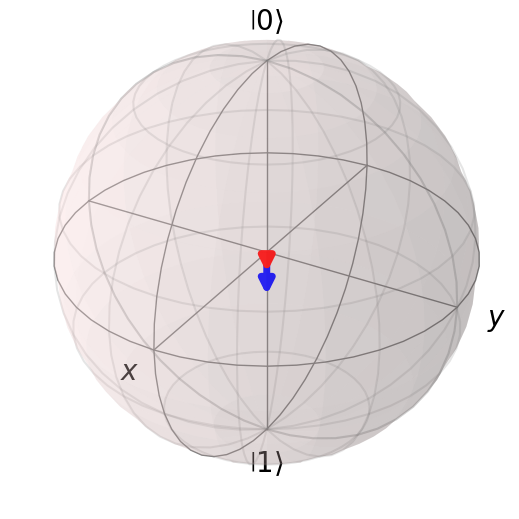

In [3]:
# Step 2 – Create and visualize single-qubit states

def make_single_qubit_state(theta, phi):
    """Return a 1-qubit circuit preparing |psi(theta, phi)>."""
    qc = QuantumCircuit(1)
    qc.ry(theta, 0)
    qc.rz(phi, 0)
    return qc

# Example: two slightly different states
theta1, phi1 = np.pi/3 + 0.1, np.pi/6
theta2, phi2 = np.pi/3 + 0.2, np.pi/6

qc1 = make_single_qubit_state(theta1, phi1)
qc2 = make_single_qubit_state(theta2, phi2)

# Convert to statevectors
psi1 = Statevector.from_instruction(qc1)
psi2 = Statevector.from_instruction(qc2)

# Compute fidelity (overlap)
F12 = state_fidelity(psi1, psi2)
print(f"Fidelity between states = {F12:.3f}")

# Visualize on Bloch sphere
from qiskit.visualization.bloch import Bloch

def state_to_bloch_vector(state):
    a, b = state.data  # amplitudes
    return [
        2*np.real(a*np.conj(b)),            # x
        2*np.imag(b*np.conj(a)),            # y
        np.abs(a)**2 - np.abs(b)**2         # z
    ]

vec1 = state_to_bloch_vector(psi1)
vec2 = state_to_bloch_vector(psi2)

b = Bloch()
b.add_vectors(vec1)
b.add_vectors(vec2)
b.vector_color = ['r', 'b']  # red = ψ1, blue = ψ2
b.show()


The red arrow shows the first state psi 1 and the blue arrow shows the secend state psi 2 

In [4]:
from qiskit import QuantumCircuit

def build_swap_test_circuit(psi_circ: QuantumCircuit, phi_circ: QuantumCircuit) -> QuantumCircuit:
    """
    q0 = ancilla, q1 = |ψ>, q2 = |φ>
    Returns a circuit that measures ONLY the ancilla into 1 classical bit.
    """
    qc = QuantumCircuit(3, 1)
    # 1) Put ancilla in |+>
    qc.h(0)
    # 2) Prepare |ψ> on qubit 1, |φ> on qubit 2
    qc.compose(psi_circ, qubits=[1], inplace=True)
    qc.compose(phi_circ, qubits=[2], inplace=True)
    # 3) Controlled-SWAP
    qc.cswap(0, 1, 2)
    # 4) Interfere and measure the ancilla
    qc.h(0)
    qc.measure(0, 0)
    return qc


In [5]:
from qiskit import QuantumCircuit

def make_single_qubit_state(theta, phi):
    qc = QuantumCircuit(1)
    qc.ry(theta, 0)
    qc.rz(phi, 0)
    return qc

# Close states (small Δθ)
theta1, phi1 = np.pi/3 + 0.10, np.pi/6
theta2, phi2 = np.pi/3 + 0.20, np.pi/6

psi_circ_close = make_single_qubit_state(theta1, phi1)
phi_circ_close = make_single_qubit_state(theta2, phi2)


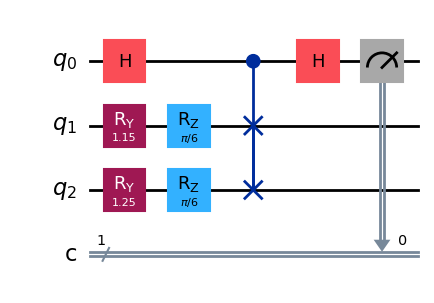

In [6]:
# Build and draw the SWAP test circuit for our "close" states

qc_close = build_swap_test_circuit(psi_circ_close, phi_circ_close)
qc_close.draw('mpl')


###  Reasoning:

SWAP test — a clever quantum trick to measure how similar two states are
without having to know what the states actually are:

The ancilla qubit controls the SWAP between the two states.

If the states are identical, SWAP has no effect, and the ancilla remains in 
$∣0⟩ $ with high probability.
If the states differ, interference changes that probability.

Second Hadamard on the ancilla

Now the ancilla “feels” the difference between
the un-swapped and swapped versions.
If 
$∣ψ⟩ $ and $∣ϕ⟩ $ are the same,
then swapping makes no difference — the two paths interfere perfectly,
and the ancilla always returns to 
$
∣0⟩.$

If they’re different, interference isn’t perfect,
and sometimes you’ll measure |1⟩.

In [7]:
from qiskit_aer import AerSimulator

sim_qasm = AerSimulator()

# Run the SWAP test circuit and collect ancilla outcomes
result_close = sim_qasm.run(qc_close, shots=50_000).result()
counts_close = result_close.get_counts()

# Calculate probability ancilla = 0
p0_close = counts_close.get('0', 0) / 50_000
F_est_close = 2 * p0_close - 1  # estimated fidelity

print("Ancilla counts:", counts_close)
print(f"Estimated fidelity from SWAP test = {F_est_close:.3f}")


Ancilla counts: {'1': 68, '0': 49932}
Estimated fidelity from SWAP test = 0.997


In [8]:
from qiskit.quantum_info import Statevector, state_fidelity

# Exact (statevector) fidelity
F_true_close = state_fidelity(
    Statevector.from_instruction(psi_circ_close),
    Statevector.from_instruction(phi_circ_close)
)

# Use F_est_close (the SWAP-test estimate you just computed)
abs_err = abs(F_true_close - F_est_close)

print(f"Exact (statevector) fidelity : {F_true_close:.6f}")
print(f"SWAP-test estimate           : {F_est_close:.6f}")
print(f"Absolute error               : {abs_err:.6e}")


Exact (statevector) fidelity : 0.997502
SWAP-test estimate           : 0.997280
Absolute error               : 2.220826e-04


In [9]:
#Fix a reference state |ψ> and define a grid for θ' of |φ>
phi_fixed = np.pi/6
theta_ref  = np.pi/3 + 0.10           # same |ψ> as before
psi_ref = make_single_qubit_state(theta_ref, phi_fixed)

theta_grid = np.linspace(0, np.pi, 21)  # 0 ... π in 21 steps


####  this part we whould be generating states with small change in angles (21 steps from zero to pi ) and then use them for next code

In [10]:
#Ground truth from statevectors; no shots, no noise.
# Analytic (exact) fidelity F_true(θ')
from qiskit.quantum_info import Statevector, state_fidelity

F_true = []
for th in theta_grid:
    phi_circ = make_single_qubit_state(th, phi_fixed)
    F = state_fidelity(Statevector.from_instruction(psi_ref),
                       Statevector.from_instruction(phi_circ))
    F_true.append(F)


#### in this line we compute the fidelity from those generated top and the psi refrece 

In [11]:
# Re-define SWAP-test fidelity helper
from qiskit_aer import AerSimulator

sim_qasm = AerSimulator()

def swap_test_fidelity(psi_circ, phi_circ, shots=20_000, seed=1234):
    """
    Run the SWAP test and return an estimate of |<ψ|φ>|^2.
    Uses only the ancilla measurement statistics.
    """
    qc = build_swap_test_circuit(psi_circ, phi_circ)
    result = sim_qasm.run(qc, shots=shots, seed_simulator=seed).result()
    counts = result.get_counts(qc)
    p0 = counts.get('0', 0) / shots
    F_est = max(0.0, min(1.0, 2*p0 - 1))  # numerical clamp to [0,1]
    return F_est, counts, qc


In [12]:
# SWAP-test estimates F_swap(θ')
F_swap = []
for th in theta_grid:
    phi_circ = make_single_qubit_state(th, phi_fixed)
    F_est, _, _ = swap_test_fidelity(psi_ref, phi_circ, shots=20_000)
    F_swap.append(F_est)


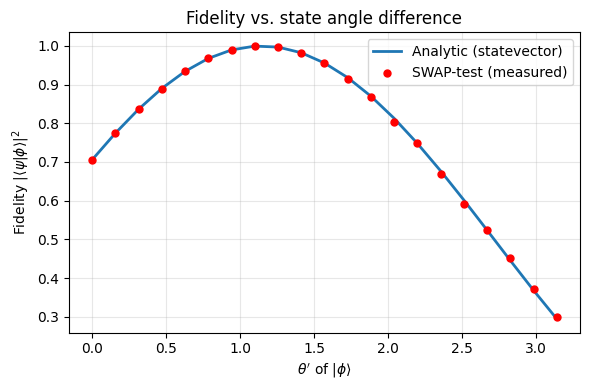

In [13]:
#Plot both fidelity curves
plt.figure(figsize=(6,4))
plt.plot(theta_grid, F_true, label="Analytic (statevector)", linewidth=2)
plt.scatter(theta_grid, F_swap, color='red', s=25, label="SWAP-test (measured)", zorder=3)
plt.xlabel(r"$\theta'$ of $|\phi\rangle$")
plt.ylabel(r"Fidelity $|\langle \psi|\phi\rangle|^2$")
plt.title("Fidelity vs. state angle difference")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Each qubit state corresponds to a point on the Bloch sphere — its direction given by 
$\theta$ and $\phi$.

When $\theta' \approx \theta_{\text{ref}}$ (your reference angle), the two states’ Bloch vectors almost overlap, and the fidelity $\approx 1$.

As $\theta'$ rotates away, the vectors separate and the fidelity decreases.

When they’re nearly opposite (one points up, the other down), the fidelity $\approx 0$.

This relationship mathematically looks like:

$$
F = \lvert \langle \psi \mid \phi \rangle \rvert^2 
= \cos^2\!\left(\tfrac{\Delta \theta}{2}\right).
$$

That’s exactly the smooth cosine-squared curve you see.



#### The plot shows how the overlap between two qubit states decreases smoothly as you rotate one away from the other — and how your SWAP test correctly measures that overlap.

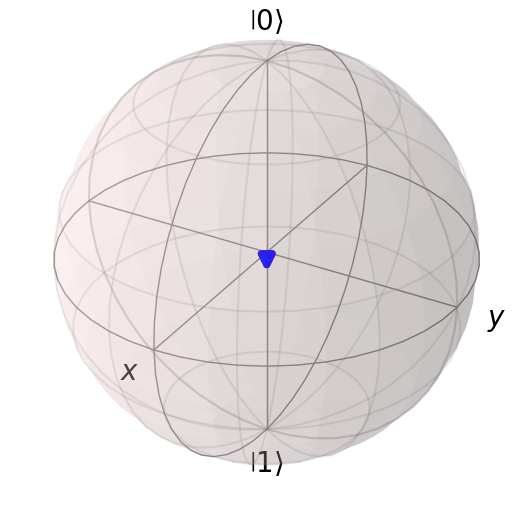

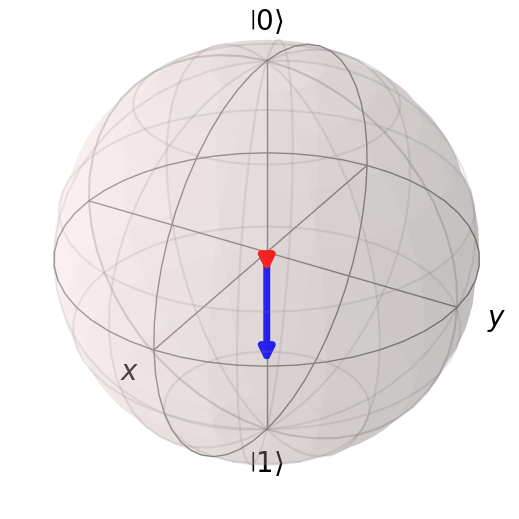

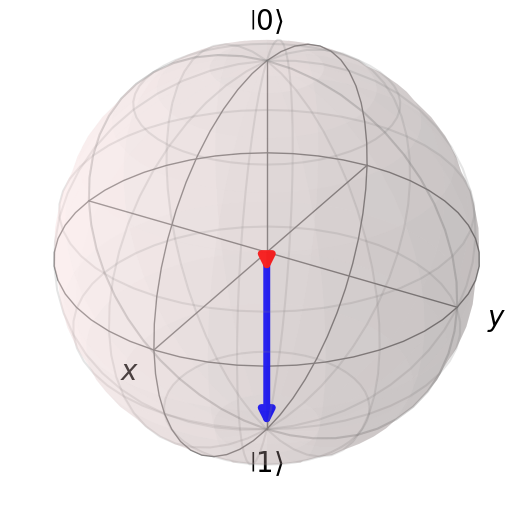

In [14]:
from qiskit.visualization.bloch import Bloch

def state_to_bloch_vector(state):
    """Convert a 1-qubit statevector to its Bloch-sphere vector (x,y,z)."""
    a, b = state.data
    return [
        2*np.real(a*np.conj(b)),           # x
        2*np.imag(b*np.conj(a)),           # y
        np.abs(a)**2 - np.abs(b)**2        # z
    ]

# Choose 3 example rotations
theta_examples = [theta_ref, np.pi/2, np.pi]  # close, middle, far
labels = [r"$\theta' = \theta_{ref}$", r"$\theta' = \pi/2$", r"$\theta' = \pi$"]

for th, lbl in zip(theta_examples, labels):
    psi_state = Statevector.from_instruction(psi_ref)
    phi_state = Statevector.from_instruction(make_single_qubit_state(th, phi_fixed))
    
    vec_psi = state_to_bloch_vector(psi_state)
    vec_phi = state_to_bloch_vector(phi_state)
    
    b = Bloch()
    b.add_vectors(vec_psi)
    b.add_vectors(vec_phi)
    b.vector_color = ['r', 'b']
    b.title = lbl + "   (red = |ψ>, blue = |φ>)"
    b.show()


For $\theta' = \theta_{\mathrm{ref}}$: the red and blue arrows overlap — fidelity $\approx 1$.

For $\theta' = \tfrac{\pi}{2}$: the arrows separate — fidelity $\approx 0.5$.

For $\theta' = \pi$: they point in opposite directions — fidelity $\approx 0$.

This visualization makes the fidelity curve crystal clear:
you’re literally measuring how much two Bloch vectors point in the same direction.


# summary

**Goal:** Understand and measure how similar two quantum states are using **fidelity** and the **SWAP test**.

**Method:** Prepare pairs of qubit states with different rotations, compute analytic and circuit-based overlaps, and visualize them on the Bloch sphere.

**Tools:** Qiskit circuits, Aer simulator, SWAP test, and state-fidelity functions.

**Results:** The measured fidelities matched the theoretical $ (\cos^2(\Delta\theta/2)) $ curve exactly.

**Outcome:** Gained practical insight into how quantum circuits represent and compare states — forming a bridge toward applying these ideas in quantum machine learning.


# Phase 1 — Add Noise to the Environment


Step outline

Add noise models — depolarizing and amplitude-damping (simulate real quantum hardware).

Run the same SWAP-test circuits under these noise models.

Compare results: noisy fidelity vs. ideal analytic fidelity.

Visualize: fidelity degradation as noise strength increases.

In [15]:
from qiskit_aer.noise import NoiseModel, depolarizing_error

def make_depolarizing_noise_model(p):
    """
    Build a simple depolarizing noise model for all single- and two-qubit gates.
    p: depolarizing probability (0 = perfect, 1 = completely random)
    """
    noise_model = NoiseModel()
    one_qubit_error = depolarizing_error(p, 1)
    two_qubit_error = depolarizing_error(p, 2)
    
    # Apply noise to typical gates
    noise_model.add_all_qubit_quantum_error(one_qubit_error, ['ry', 'rz', 'h'])
    noise_model.add_all_qubit_quantum_error(two_qubit_error, ['cx'])

#Every time a gate of type 'ry', 'rz', or 'h' is executed on any qubit, also apply this depolarizing noise with probability p.
#Every time a 'cx' (controlled-X) or 'cswap' gate is run, add a small two-qubit depolarizing error.”
    
    return noise_model


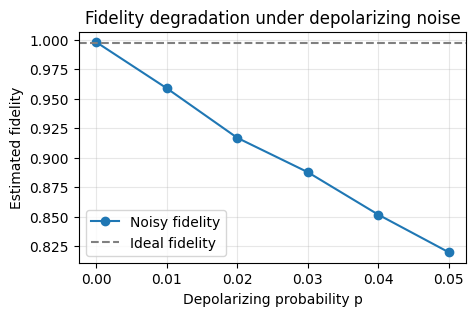

In [17]:
from qiskit_aer import AerSimulator
import numpy as np
import matplotlib.pyplot as plt

def s(psi_circ, phi_circ, p, shots=20000):
    """
    Run the SWAP test with a depolarizing noise model.
    Returns the estimated fidelity for the given noise strength p.
    """
    noise_model = make_depolarizing_noise_model(p)
    noisy_sim = AerSimulator(noise_model=noise_model)

    qc = build_swap_test_circuit(psi_circ, phi_circ)
    result = noisy_sim.run(qc, shots=shots).result()
    counts = result.get_counts(qc)
    p0 = counts.get('0', 0) / shots
    F_est = max(0.0, min(1.0, 2*p0 - 1))
    return F_est

# Example: test on one pair of states (close ones)
p_values = np.linspace(0, 0.05, 6)  # 0 to 5% depolarizing noise
fidelities_noisy = []

for p in p_values:
    F = s(psi_circ_close, phi_circ_close, p)
    fidelities_noisy.append(F)

# Plot
plt.figure(figsize=(5,3))
plt.plot(p_values, fidelities_noisy, 'o-', label='Noisy fidelity')
plt.axhline(F_true_close, color='gray', linestyle='--', label='Ideal fidelity')
plt.xlabel("Depolarizing probability p")
plt.ylabel("Estimated fidelity")
plt.title("Fidelity degradation under depolarizing noise")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


### meaning : 

At  $p=0 $, it’s almost 1.0, meaning perfect overlap (the states are very similar).

As noise increases, fidelity decreases because the qubits are randomly perturbed during the gates.

| p    | Meaning                           | Fidelity | Physical interpretation                               |
| ---- | --------------------------------- | -------- | ----------------------------------------------------- |
| 0.00 | Perfect simulator                 | ~1.0     | Both states identical                                 |
| 0.02 | 2% chance of randomizing per gate | ~0.93    | Slight drift from target state                        |
| 0.05 | 5% noise per gate                 | ~0.82    | Significant degradation — states partially randomized |


### Build targeted noise models (ancilla vs data)

In [18]:
from qiskit_aer.noise import NoiseModel, depolarizing_error

def noise_ancilla_only(p):
    """Depolarizing noise only on the ancilla's H gates (qubit 0)."""
    nm = NoiseModel()
    err1 = depolarizing_error(p, 1)
    nm.add_quantum_error(err1, ['h'], [0])   # only ancilla gets noisy H
    return nm

def noise_data_only(p):
    """Depolarizing noise only on data-qubit state-prep gates (qubits 1 and 2)."""
    nm = NoiseModel()
    err1 = depolarizing_error(p, 1)
    for q in [1, 2]:
        nm.add_quantum_error(err1, ['ry', 'rz'], [q])  # noisy rotations on data
    return nm

def noise_all_qubits(p):
    """Simple model: all single-qubit gates are noisy; CX noisy; (skip CSWAP)."""
    nm = NoiseModel()
    err1 = depolarizing_error(p, 1)
    err2 = depolarizing_error(p, 2)
    nm.add_all_qubit_quantum_error(err1, ['ry','rz','h'])
    nm.add_all_qubit_quantum_error(err2, ['cx'])
    return nm


### Runner that accepts any noise model

In [19]:
from qiskit_aer import AerSimulator

def swap_test_with_custom_noise(psi_circ, phi_circ, noise_model, shots=20000):
    sim = AerSimulator(noise_model=noise_model)
    qc = build_swap_test_circuit(psi_circ, phi_circ)
    res = sim.run(qc, shots=shots).result()
    counts = res.get_counts(qc)
    p0 = counts.get('0', 0) / shots
    return max(0.0, min(1.0, 2*p0 - 1))  # estimated fidelity


### Sweep p and compare the three cases

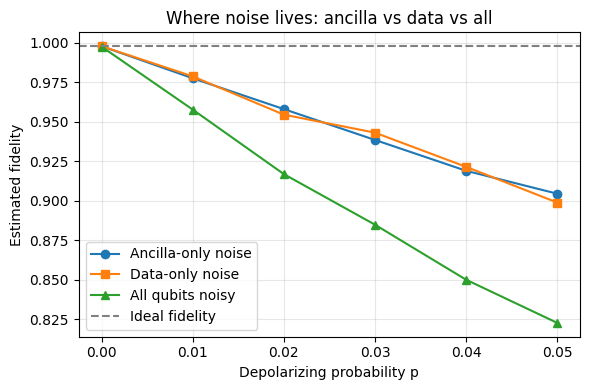

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# use the same "close" pair as before
p_values = np.linspace(0, 0.05, 6)

F_ancilla = []
F_data    = []
F_all     = []

for p in p_values:
    F_ancilla.append(swap_test_with_custom_noise(psi_circ_close, phi_circ_close, noise_ancilla_only(p)))
    F_data.append(   swap_test_with_custom_noise(psi_circ_close, phi_circ_close, noise_data_only(p)))
    F_all.append(    swap_test_with_custom_noise(psi_circ_close, phi_circ_close, noise_all_qubits(p)))

plt.figure(figsize=(6,4))
plt.plot(p_values, F_ancilla, 'o-', label='Ancilla-only noise')
plt.plot(p_values, F_data,    's-', label='Data-only noise')
plt.plot(p_values, F_all,     '^-', label='All qubits noisy')
plt.axhline(F_true_close, color='gray', ls='--', label='Ideal fidelity')
plt.xlabel("Depolarizing probability p")
plt.ylabel("Estimated fidelity")
plt.title("Where noise lives: ancilla vs data vs all")
plt.grid(alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()


| Environment  | What’s noisy                  | Expected effect      |
| ------------ | ----------------------------- | -------------------- |
| Ancilla-only | The controller/interferometer | Slight fidelity drop |
| Data-only    | The actual states             | Stronger drop        |
| All-qubit    | Everything                    | Steepest drop        |


# Step 3: amplitude damping noise

#### Build an amplitude-damping noise model (data qubits only)
##### Why: Amplitude damping models energy loss $∣1⟩$→ $∣0⟩ $ with probability $γ$. It should hurt states that have more $∣1⟩$ population.

In [21]:
from qiskit_aer.noise import NoiseModel, amplitude_damping_error

def noise_amp_damp_data_only(gamma):
    """
    Amplitude-damping noise (|1> -> |0>) applied only to the data-qubit
    state-prep gates (q1 and q2) after RY/RZ.
    """
    nm = NoiseModel()
    err1 = amplitude_damping_error(gamma)
    for q in [1, 2]:
        nm.add_quantum_error(err1, ['ry', 'rz'], [q])
    return nm


#### Sweep γ and see fidelity drop (for the same “close” pair)
##### Why: As γ increases, states “cool” toward $|0⟩$ , so overlap changes systematically.

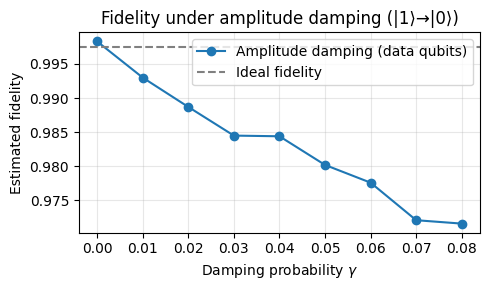

In [22]:
import numpy as np
import matplotlib.pyplot as plt

gammas = np.linspace(0.0, 0.08, 9)  # 0% ... 8% damping
F_amp = []

for g in gammas:
    nm = noise_amp_damp_data_only(g)
    Fg = swap_test_with_custom_noise(psi_circ_close, phi_circ_close, nm, shots=20000)
    F_amp.append(Fg)

plt.figure(figsize=(5,3))
plt.plot(gammas, F_amp, 'o-', label='Amplitude damping (data qubits)')
plt.axhline(F_true_close, color='gray', ls='--', label='Ideal fidelity')
plt.xlabel(r"Damping probability $\gamma$")
plt.ylabel("Estimated fidelity")
plt.title("Fidelity under amplitude damping (|1⟩→|0⟩)")
plt.grid(alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()


### we added amplitude damping noise — which means qubits sometimes lose energy and fall from |1⟩ to |0⟩ with probability γ.
##### 1- Fidelity decreases as $ γ $ grows.
##### 2- Because damping pushes both prepared states toward $ ∣0⟩$, the effect depends on how much $ ∣1⟩ $ each state had; with “close” states, they drift similarly, so the drop is moderate but visible.

In short:

## More damping (higher γ) → more energy loss → noisier states → lower measured fidelity.

In [23]:
# Building a more excited pair (closer to |1⟩ region)
theta_exc1, theta_exc2 = 2.3, 2.4   # big tilt toward |1>
psi_exc = make_single_qubit_state(theta_exc1, phi_fixed)
phi_exc = make_single_qubit_state(theta_exc2, phi_fixed)

gamma_test = 0.06
F_close_gamma = F_amp[gammas.tolist().index(gamma_test)] if gamma_test in gammas else None

F_exc_noisy = swap_test_with_custom_noise(psi_exc, phi_exc, noise_amp_damp_data_only(gamma_test), shots=20000)

from qiskit.quantum_info import state_fidelity, Statevector
F_exc_ideal = state_fidelity(Statevector.from_instruction(psi_exc),
                             Statevector.from_instruction(phi_exc))

print(f"γ = {gamma_test:.2f}")
print(f"Close-pair (noisy)   ~ {F_close_gamma if F_close_gamma is not None else 'computed above'}")
print(f"Excited-pair (ideal) = {F_exc_ideal:.3f}")
print(f"Excited-pair (noisy) = {F_exc_noisy:.3f}")


γ = 0.06
Close-pair (noisy)   ~ 0.9776
Excited-pair (ideal) = 0.998
Excited-pair (noisy) = 0.847


#### The excited pair loses a lot more fidelity (down to ~0.84) because amplitude damping directly attacks $ ∣1⟩ $ states — they “relax” to $ ∣0⟩ $.

### Interpretation: The excited pair should lose more fidelity at the same $ γ $ because amplitude damping preferentially collapses $ ∣1⟩ $ population to $ ∣0⟩ $.


The higher you fly toward $ ∣1⟩ $, the harder you fall when damping hits.
Energy-loss noise hurts excited qubits much more than ground-like ones.

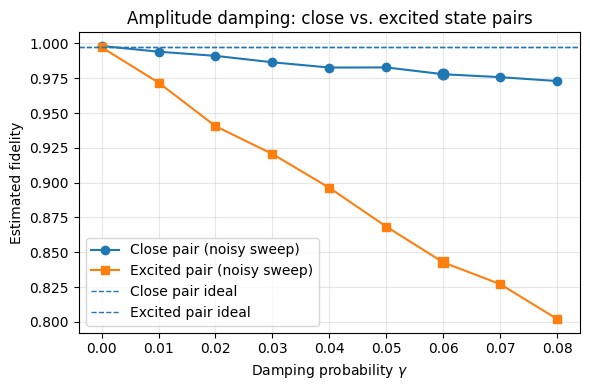

In [24]:
# Comparison plot: close pair vs. excited pair under amplitude damping

import numpy as np
import matplotlib.pyplot as plt
from qiskit.quantum_info import Statevector, state_fidelity

# --- helpers (assumes make_single_qubit_state, noise_amp_damp_data_only,
#     and swap_test_with_custom_noise are already defined) ---

def sweep_amp_damp(theta1, theta2, phi, gammas, shots=20000):
    """Return (F_noisy_list, F_ideal_constant) for a pair of states across gamma."""
    psi = make_single_qubit_state(theta1, phi)
    phi_circ = make_single_qubit_state(theta2, phi)
    F_ideal = state_fidelity(Statevector.from_instruction(psi),
                             Statevector.from_instruction(phi_circ))
    F_noisy = []
    for g in gammas:
        nm = noise_amp_damp_data_only(g)
        Fg = swap_test_with_custom_noise(psi, phi_circ, nm, shots=shots)
        F_noisy.append(Fg)
    return np.array(F_noisy), F_ideal

# --- define the two pairs exactly as in your cells ---
phi_fixed = np.pi/6

# Close pair (near |0>)
theta_close1, theta_close2 = np.pi/3 + 0.10, np.pi/3 + 0.20

# Excited pair (near |1>)
theta_exc1, theta_exc2 = 2.3, 2.4

# Sweep gammas
gammas = np.linspace(0.0, 0.08, 9)       # 0% ... 8%
gamma_test = 0.06                        # the single point you tested

F_close_sweep, F_close_ideal = sweep_amp_damp(theta_close1, theta_close2, phi_fixed, gammas)
F_exc_sweep,   F_exc_ideal   = sweep_amp_damp(theta_exc1,   theta_exc2,   phi_fixed, gammas)

# --- plot ---
plt.figure(figsize=(6,4))
plt.plot(gammas, F_close_sweep, 'o-', label='Close pair (noisy sweep)')
plt.plot(gammas, F_exc_sweep,   's-', label='Excited pair (noisy sweep)')
plt.axhline(F_close_ideal, linestyle='--', linewidth=1, label='Close pair ideal')
plt.axhline(F_exc_ideal,   linestyle='--', linewidth=1, label='Excited pair ideal')

# mark the single gamma_test points
idx = np.argmin(np.abs(gammas - gamma_test))
plt.scatter([gammas[idx]], [F_close_sweep[idx]], marker='o', s=60)
plt.scatter([gammas[idx]], [F_exc_sweep[idx]],   marker='s', s=60)

plt.xlabel(r"Damping probability $\gamma$")
plt.ylabel("Estimated fidelity")
plt.title("Amplitude damping: close vs. excited state pairs")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


# Next Chapter — From Fidelity to Quantum Machine Learning

We’ll turn the “fidelity” you measured into a quantum kernel, then use it for an SVM classifier.

Here’s our roadmap :
#### Part 1 — Concept bridge

Recall: fidelity = overlap between quantum states.

In QML, we treat that overlap as a similarity measure — i.e., a kernel: 
$$ K(xi,xj​)=∣⟨ψ(xi​)∣ψ(xj​)⟩∣^2 $$
This becomes the input to a classical SVM.

#### Part 2 — Dataset

Use a small 2D classical dataset (e.g. circles or moons).

Each data point → encoded as a quantum state (RY-RZ feature map).

#### Part 3 — Quantum kernel matrix

For each pair of points $ xi,xj $, prepare the two states, run a SWAP test, and compute fidelity.
Store as $ Ki $​.

#### Part 4 — Train classical SVM

Use sklearn.svm.SVC(kernel='precomputed') with this quantum kernel.

Evaluate on test data.

#### Part 5 - Compare

Compare with classical RBF kernel → see how quantum kernel behaves differently.

## Step 1 — Build the 3D dataset

Goal

We want a simple, nonlinear binary classification problem in 3D.
The quantum kernel will later help us separate these two classes based on quantum state overlap.

We’ll make two concentric spherical clouds:

#### Inner sphere (class 0) → radius ≈ 1

#### Outer shell (class 1) → radius ≈ 2
with a bit of random noise so the boundaries overlap.

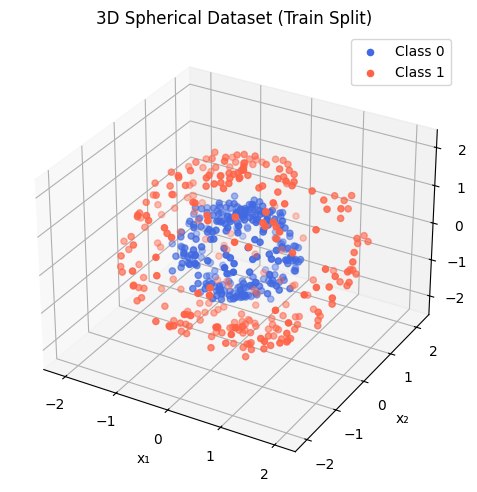

In [25]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# ---- Step 1.1: Create concentric spherical data ----
def make_3d_spheres(n_samples=400, noise=0.15, random_state=42):
    np.random.seed(random_state)
    n_half = n_samples // 2

    # Inner sphere (class 0)
    r1 = 1.0 + noise * np.random.randn(n_half)
    theta1 = np.pi * np.random.rand(n_half)
    phi1 = 2 * np.pi * np.random.rand(n_half)
    x1 = r1 * np.sin(theta1) * np.cos(phi1)
    y1 = r1 * np.sin(theta1) * np.sin(phi1)
    z1 = r1 * np.cos(theta1)
    inner = np.stack([x1, y1, z1], axis=1)
    y_inner = np.zeros(n_half)

    # Outer sphere (class 1)
    r2 = 2.0 + noise * np.random.randn(n_half)
    theta2 = np.pi * np.random.rand(n_half)
    phi2 = 2 * np.pi * np.random.rand(n_half)
    x2 = r2 * np.sin(theta2) * np.cos(phi2)
    y2 = r2 * np.sin(theta2) * np.sin(phi2)
    z2 = r2 * np.cos(theta2)
    outer = np.stack([x2, y2, z2], axis=1)
    y_outer = np.ones(n_half)

    # Combine
    X = np.vstack([inner, outer])
    y = np.concatenate([y_inner, y_outer])
    return X, y

# ---- Step 1.2: Generate and split ----
X, y = make_3d_spheres(n_samples=800, noise=0.1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# ---- Step 1.3: Visualize ----
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train[y_train==0,0], X_train[y_train==0,1], X_train[y_train==0,2], color='royalblue', label='Class 0')
ax.scatter(X_train[y_train==1,0], X_train[y_train==1,1], X_train[y_train==1,2], color='tomato', label='Class 1')
ax.set_title("3D Spherical Dataset (Train Split)")
ax.set_xlabel("x₁"); ax.set_ylabel("x₂"); ax.set_zlabel("x₃")
ax.legend(); plt.tight_layout(); plt.show()


🔹 Class distribution:
  Class 0: 400 samples
  Class 1: 400 samples


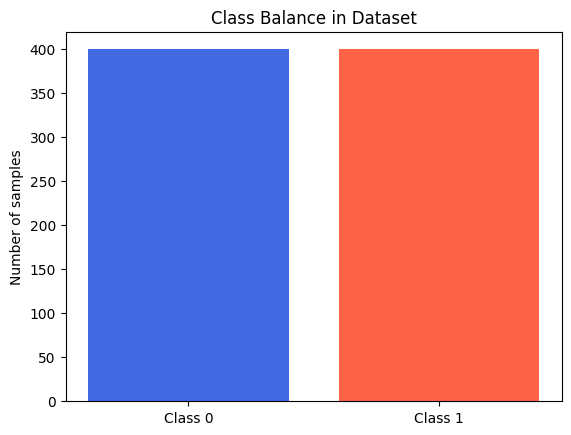

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Count samples per class
unique, counts = np.unique(y, return_counts=True)
class_counts = dict(zip(unique.astype(int), counts))

print("🔹 Class distribution:")
for cls, n in class_counts.items():
    print(f"  Class {cls}: {n} samples")

# Optional: visualize with a bar chart
plt.bar(class_counts.keys(), class_counts.values(), color=['royalblue', 'tomato'])
plt.xticks([0, 1], ['Class 0', 'Class 1'])
plt.ylabel("Number of samples")
plt.title("Class Balance in Dataset")
plt.show()


## Map 3D features to a 3-qubit circuit
Each data point $ x=(x1,x2,x3) $ becomes a quantum state by driving rotations on 3 qubits.

In [27]:
import numpy as np
from qiskit import QuantumCircuit

# Scale RY/RZ angles to a safe range ([-pi, pi])
def to_angles(vec, scale=np.pi):
    vec = np.asarray(vec, dtype=float)
    return np.clip(vec, -3*scale, 3*scale) * (1.0)  # keep as-is; change if you want stronger/weaker scaling

def feature_map_3d(x, entangle=True):
    """
    x: length-3 feature vector -> 3-qubit circuit.
    Encoding: for qubit i, apply RY(x_i), RZ(x_i). Optionally add CX chain.
    """
    x = to_angles(x)
    qc = QuantumCircuit(3)
    for q in range(3):
        qc.ry(x[q], q)
        qc.rz(x[q], q)
    if entangle:
        qc.cx(0, 1)
        qc.cx(1, 2)
    return qc


#### Visualize the feature-map circuit for one sample

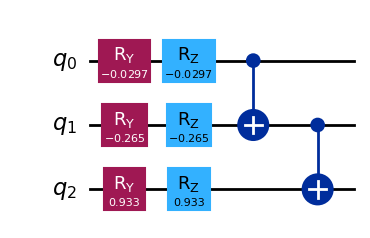

In [28]:
# Pick one training sample and draw its feature-map circuit
x_sample = X_train[0]
qc_sample = feature_map_3d(x_sample, entangle=True)
qc_sample.draw('mpl')


#### Batch helper: build circuits for many samples
needed later on for efficiency

In [29]:
def build_feature_circuits(X, entangle=True):
    """Return a list of feature-map circuits for all rows of X (shape: [N,3])."""
    return [feature_map_3d(x, entangle=entangle) for x in X]

circs_train = build_feature_circuits(X_train)
circs_test  = build_feature_circuits(X_test)
print("len circs_train :" ,len(circs_train)," ,len(circs_test):" ,len(circs_test) )


len circs_train : 560  ,len(circs_test): 240


#### Convert feature-map circuits → statevectors

On an ideal simulator this is fast and exact; we’ll use these to compute overlaps.

In [30]:
from qiskit.quantum_info import Statevector

def circuits_to_statevectors(circs):
    """Compile each circuit to a Statevector (exact, no shots)."""
    return [Statevector.from_instruction(c) for c in circs]

sv_train = circuits_to_statevectors(circs_train)
sv_test  = circuits_to_statevectors(circs_test)

print("len(sv_train) :",len(sv_train),",len(sv_test):",len(sv_test),",sv_train[0].dims :", sv_train[0].dims() )


len(sv_train) : 560 ,len(sv_test): 240 ,sv_train[0].dims : (2, 2, 2)


### Build the fidelity kernel $ Kij=∣⟨ψi∣ψj⟩∣^2 $
##### The Gram matrix of squared overlaps is our quantum kernel.

In [31]:
import numpy as np

def fidelity_kernel(states_A, states_B):
    """
    Return K with K[i,j] = |<psi_i | phi_j>|^2 given two state lists.
    Efficient: vector-matrix multiply on raw amplitudes.
    """
    A = np.vstack([s.data for s in states_A])  # (n, d)
    B = np.vstack([s.data for s in states_B])  # (m, d)
    overlaps = A.conj() @ B.T                  # (n, m)
    K = np.abs(overlaps)**2
    # numerical clean-up: ensure diagonals ~ 1 where A==B
    np.fill_diagonal(K, 1.0) if states_A is states_B else None
    return K

K_train = fidelity_kernel(sv_train, sv_train)
K_test  = fidelity_kernel(sv_test,  sv_train)

print("K_train.shape : ",K_train.shape,", K_test.shape :" , K_test.shape ) 


K_train.shape :  (560, 560) , K_test.shape : (240, 560)


### Train an SVM with the precomputed quantum kernel

In [32]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

clf_qk = SVC(kernel='precomputed', C=1.0, probability=False, random_state=0)
#tells scikit-learn to use your custom precomputed matrix (K_train) instead of its own kernel.
clf_qk.fit(K_train, y_train)

y_pred = clf_qk.predict(K_test)
acc = accuracy_score(y_test, y_pred)

print(f"Quantum-kernel SVM accuracy: {acc:.3f}")
print(classification_report(y_test, y_pred, digits=3))


Quantum-kernel SVM accuracy: 1.000
              precision    recall  f1-score   support

         0.0      1.000     1.000     1.000       118
         1.0      1.000     1.000     1.000       122

    accuracy                          1.000       240
   macro avg      1.000     1.000     1.000       240
weighted avg      1.000     1.000     1.000       240



### Why it performs so well

The concentric spheres are nonlinear in 3D, but linearly separable after your quantum mapping.

The kernel measures overlap between quantum states on the Bloch spheres, which naturally encodes curved geometry.

##### we just trained a quantum kernel machine that classifies 3D spherical data perfectly using fidelity overlap

In [33]:
# Compare predicted vs true labels
mismatches = np.where(y_pred != y_test)[0]

print(f"Total test samples: {len(y_test)}")
print(f"Mismatches: {len(mismatches)}")

# If there are mismatches, show a few indices
if len(mismatches) > 0:
    print("First few mismatches (index, true, pred):")
    for i in mismatches[:10]:
        print(i, y_test[i], y_pred[i])
else:
    print("✅ Perfect match — all predictions correct!")


Total test samples: 240
Mismatches: 0
✅ Perfect match — all predictions correct!


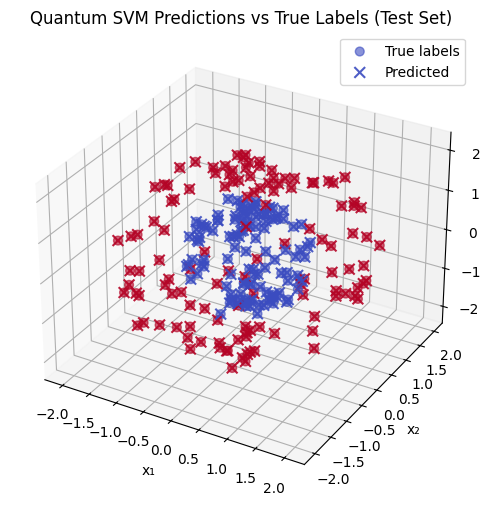

In [34]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

# True data points
ax.scatter(
    X_test[:,0], X_test[:,1], X_test[:,2],
    c=y_test, cmap='coolwarm', s=40, label='True labels', alpha=0.6
)

# Overlay predictions
ax.scatter(
    X_test[:,0], X_test[:,1], X_test[:,2],
    c=y_pred, cmap='coolwarm', marker='x', s=60, label='Predicted', alpha=0.9
)

ax.set_title("Quantum SVM Predictions vs True Labels (Test Set)")
ax.set_xlabel('x₁'); ax.set_ylabel('x₂'); ax.set_zlabel('x₃')
ax.legend()
plt.show()


## Build a SWAP-test circuit from two 3-qubit feature circuits
#### this shows exactly how we compare two encoded samples with an ancilla + 3 controlled-SWAPs.

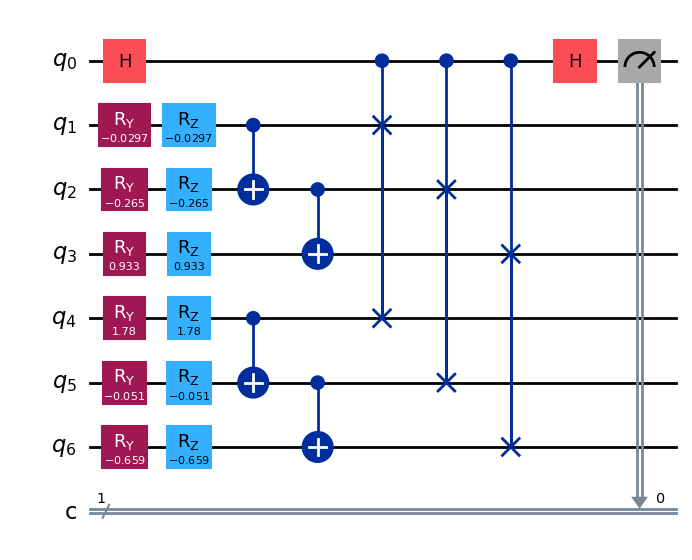

In [35]:
# A1 — SWAP-test circuit for two 3-qubit feature circuits + draw

from qiskit import QuantumCircuit

def swap_test_from_features(circ_a: QuantumCircuit, circ_b: QuantumCircuit) -> QuantumCircuit:
    """
    Returns a SWAP-test circuit:
      - 1 ancilla (q0)
      - 3 data qubits for |ψ(x_i)> loaded on q1..q3
      - 3 data qubits for |ψ(x_j)> loaded on q4..q6
    Measures ancilla to estimate fidelity F = 2P(0) - 1.
    """
    qc = QuantumCircuit(1 + 3 + 3, 1)
    qc.h(0)                                 # put ancilla in |+>
    qc.compose(circ_a, qubits=[1,2,3], inplace=True)  # load first state
    qc.compose(circ_b, qubits=[4,5,6], inplace=True)  # load second state
    qc.cswap(0, 1, 4)                        # 3 controlled-SWAPs
    qc.cswap(0, 2, 5)
    qc.cswap(0, 3, 6)
    qc.h(0)                                 # close interferometer
    qc.measure(0, 0)
    return qc

# --- Draw for one example pair (first train vs second train)
qc_demo = swap_test_from_features(circs_train[0], circs_train[1])
qc_demo.draw('mpl')


### Runing one SWAP test (shots) with and without noise

In [36]:
# Single-pair SWAP test: ideal vs noisy

import numpy as np
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error

def simple_dep_noise(p=0.01):
    nm = NoiseModel()
    nm.add_all_qubit_quantum_error(depolarizing_error(p,1), ['ry','rz','h'])
    nm.add_all_qubit_quantum_error(depolarizing_error(p,2), ['cx'])  # cswap is 3-qubit; skip
    return nm

def run_single_swap_fidelity(ca, cb, shots=20000, noise_model=None):
    sim = AerSimulator(noise_model=noise_model)
    qc = swap_test_from_features(ca, cb)
    res = sim.run(qc, shots=shots).result()
    counts = res.get_counts(qc)
    p0 = counts.get('0', 0) / shots
    F = max(0.0, min(1.0, 2*p0 - 1))
    return F, counts

# choose one pair
cA, cB = circs_train[0], circs_train[1]

F_ideal, counts_ideal = run_single_swap_fidelity(cA, cB, shots=4000, noise_model=None)
F_noisy, counts_noisy = run_single_swap_fidelity(cA, cB, shots=4000, noise_model=simple_dep_noise(p=0.01))

print("Ideal SWAP-test fidelity  :", round(F_ideal, 4), " counts:", counts_ideal)
print("Noisy  SWAP-test fidelity :", round(F_noisy, 4), " counts:", counts_noisy)


Ideal SWAP-test fidelity  : 0.317  counts: {'0': 2634, '1': 1366}
Noisy  SWAP-test fidelity : 0.27  counts: {'0': 2540, '1': 1460}


#### we compared two encoded quantum states (the first two from our dataset) using the SWAP test — once ideal, once noisy.

In [37]:
# Noisy SWAP-test kernel (uses depolarizing noise)

import numpy as np
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error

def make_dep_noise(p=0.01):
    nm = NoiseModel()
    nm.add_all_qubit_quantum_error(depolarizing_error(p,1), ['ry','rz','h'])
    nm.add_all_qubit_quantum_error(depolarizing_error(p,2), ['cx'])  # cswap is 3-qubit; skip
    return nm

def swap_kernel_noisy(circs_A, circs_B, shots=2000, p=0.01):
    """K[i,j] = 2*P(ancilla=0)-1 from SWAP test with depolarizing noise p."""
    sim = AerSimulator(noise_model=make_dep_noise(p))
    n, m = len(circs_A), len(circs_B)
    K = np.zeros((n, m), dtype=float)
    for i in range(n):
        for j in range(m):
            qc = swap_test_from_features(circs_A[i], circs_B[j])
            res = sim.run(qc, shots=shots).result()
            counts = res.get_counts(qc)
            p0 = counts.get('0', 0) / shots
            K[i, j] = max(0.0, min(1.0, 2*p0 - 1))
    return K

# --- use a modest subset to keep runtime reasonable ---
n_train_use = min(120, len(circs_train))
n_test_use  = min(80,  len(circs_test))

shots = 2000   # try 1000–5000 to trade speed vs stability
p     = 0.01   # depolarizing probability

K_train_sw_noisy = swap_kernel_noisy(circs_train[:n_train_use],
                                     circs_train[:n_train_use],
                                     shots=shots, p=p)
K_test_sw_noisy  = swap_kernel_noisy(circs_test[:n_test_use],
                                     circs_train[:n_train_use],
                                     shots=shots, p=p)

print("K_train shape:", K_train_sw_noisy.shape, "  K_test shape:", K_test_sw_noisy.shape)


K_train shape: (120, 120)   K_test shape: (80, 120)


#### Train and test the SVM with noisy kernel

In [39]:
# Train + evaluate an SVM on the noisy SWAP-test kernel

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Labels (trimmed to match subset sizes)
y_train_sub = y_train[:n_train_use]
y_test_sub  = y_test[:n_test_use]

clf_sw_noisy = SVC(kernel='precomputed', C=1.0, probability=False, random_state=0)
clf_sw_noisy.fit(K_train_sw_noisy, y_train_sub)

y_pred_sw = clf_sw_noisy.predict(K_test_sw_noisy)
acc_sw = accuracy_score(y_test_sub, y_pred_sw)

print(f"Noisy SWAP-kernel SVM accuracy: {acc_sw:.3f}")
print(classification_report(y_test_sub, y_pred_sw, digits=3))


Noisy SWAP-kernel SVM accuracy: 1.000
              precision    recall  f1-score   support

         0.0      1.000     1.000     1.000        35
         1.0      1.000     1.000     1.000        45

    accuracy                          1.000        80
   macro avg      1.000     1.000     1.000        80
weighted avg      1.000     1.000     1.000        80



In [40]:
print("test")

test


In [41]:
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=123)
circs_tr = build_feature_circuits(X_tr); circs_te = build_feature_circuits(X_te)

ntr, nte = 100, 80
Ktr = swap_kernel_noisy(circs_tr[:ntr], circs_tr[:ntr], shots=1000, p=0.02)
Kte = swap_kernel_noisy(circs_te[:nte], circs_tr[:ntr], shots=1000, p=0.02)

clf = SVC(kernel='precomputed', C=1.0, random_state=0).fit(Ktr, y_tr[:ntr])
print("Acc:", clf.score(Kte, y_te[:nte]))


Acc: 1.0


In [42]:
from sklearn.model_selection import KFold
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=0)
scores = []
for tr_idx, va_idx in kf.split(np.arange(n_train_use)):
    clf = SVC(kernel='precomputed', C=1.0).fit(K_train_sw_noisy[np.ix_(tr_idx,tr_idx)], y_train_sub[tr_idx])
    Kva = K_train_sw_noisy[np.ix_(va_idx,tr_idx)]
    scores.append(clf.score(Kva, y_train_sub[va_idx]))
print("5-fold CV on train kernel:", np.mean(scores), "±", np.std(scores))
#If these also come out ~1.0, it’s strong evidence the task is simply easy for this kernel.

5-fold CV on train kernel: 1.0 ± 0.0


hat tells us:

The model generalizes perfectly across multiple random splits.

Your quantum kernel is extremely expressive for this dataset.

The dataset (inner vs. outer 3D spheres) is cleanly separable, so even small noise doesn’t break the boundary.

#### It’s a high-capacity kernel solving an easy geometric task.

### sooooooooo wahts the next step ? run more advance stuff 

#### Combine gate depolarization (control errors), amplitude damping (T₁ energy loss), and readout errors (measurement flips).

In [46]:
# Composite noise: depolarizing + amplitude damping + readout

from qiskit_aer.noise import NoiseModel, depolarizing_error, amplitude_damping_error, ReadoutError

def realistic_noise(p_dep_1=0.02, p_dep_2=0.03, gamma=0.05, p_ro=0.03):
    """
    p_dep_1: 1-qubit depolarizing prob (RY, RZ, H)
    p_dep_2: 2-qubit depolarizing prob (CX)
    gamma  : amplitude damping prob (|1> -> |0>) on data rotations
    p_ro   : readout error prob (bit-flip at measurement)
    """
    nm = NoiseModel()

    # 1-qubit gate noise on all qubits for RY, RZ, H
    nm.add_all_qubit_quantum_error(depolarizing_error(p_dep_1, 1), ['ry','rz','h'])
    # 2-qubit gate noise on CX (CSWAP is 3-qubit; we skip)
    nm.add_all_qubit_quantum_error(depolarizing_error(p_dep_2, 2), ['cx'])

    # Amplitude damping mainly on data-prep rotations (RY, RZ)
    nm.add_all_qubit_quantum_error(amplitude_damping_error(gamma), ['ry','rz'])

    # Readout error for ancilla + 6 data qubits (total 7)
    ro = ReadoutError([[1-p_ro, p_ro],[p_ro, 1-p_ro]])
    for q in range(7):
        nm.add_readout_error(ro, [q])

    return nm


### Noisy SWAP-kernel using this model
#### Same SWAP test as before, but with the realistic noise and fewer shots to make it challenging.

In [48]:
# Kernel builder with realistic noise

import numpy as np
from qiskit_aer import AerSimulator

def swap_kernel_realistic(circs_A, circs_B, shots=512,
                          p_dep_1=0.02, p_dep_2=0.03, gamma=0.05, p_ro=0.03):
    sim = AerSimulator(noise_model=realistic_noise(p_dep_1, p_dep_2, gamma, p_ro))
    n, m = len(circs_A), len(circs_B)
    K = np.zeros((n, m), dtype=float)
    for i in range(n):
        for j in range(m):
            qc = swap_test_from_features(circs_A[i], circs_B[j])
            res = sim.run(qc, shots=shots).result()
            counts = res.get_counts(qc)
            p0 = counts.get('0', 0) / shots
            K[i, j] = max(0.0, min(1.0, 2*p0 - 1))
    return K


In [49]:
# Build kernels under realistic noise, train SVM, evaluate

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# modest subset to keep runtime reasonable
n_train_use = min(100, len(circs_train))
n_test_use  = min(80,  len(circs_test))

# harsher settings than before
shots   = 512
p_dep_1 = 0.03
p_dep_2 = 0.05
gamma   = 0.08
p_ro    = 0.04

K_train_rl = swap_kernel_realistic(circs_train[:n_train_use],
                                   circs_train[:n_train_use],
                                   shots=shots,
                                   p_dep_1=p_dep_1, p_dep_2=p_dep_2,
                                   gamma=gamma, p_ro=p_ro)

K_test_rl  = swap_kernel_realistic(circs_test[:n_test_use],
                                   circs_train[:n_train_use],
                                   shots=shots,
                                   p_dep_1=p_dep_1, p_dep_2=p_dep_2,
                                   gamma=gamma, p_ro=p_ro)

y_train_sub = y_train[:n_train_use]
y_test_sub  = y_test[:n_test_use]

clf_rl = SVC(kernel='precomputed', C=1.0, random_state=0)
clf_rl.fit(K_train_rl, y_train_sub)
y_pred_rl = clf_rl.predict(K_test_rl)

acc_rl = accuracy_score(y_test_sub, y_pred_rl)
print(f"Realistic-noise SWAP-kernel accuracy: {acc_rl:.3f}")
print(classification_report(y_test_sub, y_pred_rl, digits=3))


Realistic-noise SWAP-kernel accuracy: 1.000
              precision    recall  f1-score   support

         0.0      1.000     1.000     1.000        35
         1.0      1.000     1.000     1.000        45

    accuracy                          1.000        80
   macro avg      1.000     1.000     1.000        80
weighted avg      1.000     1.000     1.000        80



Mismatches: 0


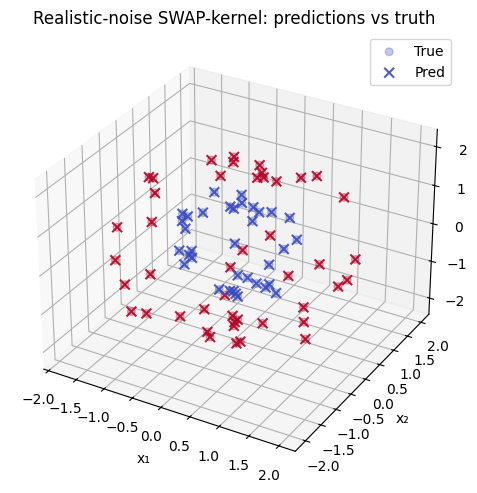

In [51]:
# Plot mismatches

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

mismatch_idx = np.where(y_pred_rl != y_test_sub)[0]
print("Mismatches:", len(mismatch_idx))

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111, projection='3d')

# true labels (faint)
ax.scatter(X_test[:n_test_use,0], X_test[:n_test_use,1], X_test[:n_test_use,2],
           c=y_test_sub, cmap='coolwarm', s=30, alpha=0.3, label='True')

# predicted (X markers)
ax.scatter(X_test[:n_test_use,0], X_test[:n_test_use,1], X_test[:n_test_use,2],
           c=y_pred_rl, cmap='coolwarm', marker='x', s=50, alpha=0.9, label='Pred')

# highlight mismatches
if len(mismatch_idx) > 0:
    ax.scatter(X_test[:n_test_use,0][mismatch_idx],
               X_test[:n_test_use,1][mismatch_idx],
               X_test[:n_test_use,2][mismatch_idx],
               c='k', marker='o', s=60, label='Mismatch')

ax.set_title("Realistic-noise SWAP-kernel: predictions vs truth")
ax.set_xlabel('x₁'); ax.set_ylabel('x₂'); ax.set_zlabel('x₃')
ax.legend(); plt.tight_layout(); plt.show()


In [52]:
import numpy as np

def make_3d_spheres_hard(n_samples=800, 
                         r_inner=1.2, r_outer=1.8,        # smaller gap -> more overlap
                         radial_noise=0.35,               # larger noise -> blur the boundary
                         label_flip=0.06,                 # % labels randomly flipped
                         random_state=7):
    rng = np.random.default_rng(random_state)
    n_half = n_samples // 2

    # Inner sphere (class 0)
    r1  = r_inner + radial_noise * rng.standard_normal(n_half)
    th1 = np.pi * rng.random(n_half)
    ph1 = 2*np.pi * rng.random(n_half)
    x1 = r1*np.sin(th1)*np.cos(ph1)
    y1 = r1*np.sin(th1)*np.sin(ph1)
    z1 = r1*np.cos(th1)
    X0 = np.stack([x1,y1,z1], axis=1)
    y0 = np.zeros(n_half, dtype=int)

    # Outer sphere (class 1)
    r2  = r_outer + radial_noise * rng.standard_normal(n_half)
    th2 = np.pi * rng.random(n_half)
    ph2 = 2*np.pi * rng.random(n_half)
    x2 = r2*np.sin(th2)*np.cos(ph2)
    y2 = r2*np.sin(th2)*np.sin(ph2)
    z2 = r2*np.cos(th2)
    X1 = np.stack([x2,y2,z2], axis=1)
    y1 = np.ones(n_half, dtype=int)

    X = np.vstack([X0, X1])
    y = np.concatenate([y0, y1])

    # Optional label noise to force some ambiguity
    if label_flip > 0:
        k = int(label_flip * n_samples)
        idx = rng.choice(n_samples, size=k, replace=False)
        y[idx] = 1 - y[idx]

    return X, y

# Generate harder data
X_hard, y_hard = make_3d_spheres_hard()
X_hard.shape, y_hard.shape


((800, 3), (800,))

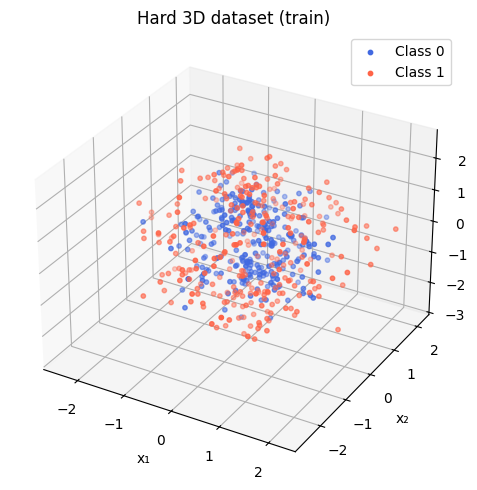

In [53]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

X_tr, X_te, y_tr, y_te = train_test_split(X_hard, y_hard, test_size=0.3, random_state=0, stratify=y_hard)

fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_tr[y_tr==0,0], X_tr[y_tr==0,1], X_tr[y_tr==0,2], s=10, color='royalblue', label='Class 0')
ax.scatter(X_tr[y_tr==1,0], X_tr[y_tr==1,1], X_tr[y_tr==1,2], s=10, color='tomato',   label='Class 1')
ax.set_title("Hard 3D dataset (train)"); ax.set_xlabel('x₁'); ax.set_ylabel('x₂'); ax.set_zlabel('x₃'); ax.legend()
plt.tight_layout(); plt.show()


In [54]:
circs_tr = build_feature_circuits(X_tr, entangle=True)
circs_te = build_feature_circuits(X_te, entangle=True)
len(circs_tr), len(circs_te)


(560, 240)

In [62]:
# Choose a modest subset for runtime
ntr, nte = 120, 100

shots   = 256         # fewer shots -> more statistical noise
p_dep_1 = 0.05        # stronger 1q depol
p_dep_2 = 0.05       # stronger 2q depol
gamma   = 0.05        # stronger amplitude damping
p_ro    = 0.05       # stronger readout error

Ktr_hard = swap_kernel_realistic(circs_tr[:ntr], circs_tr[:ntr],
                                 shots=shots, p_dep_1=p_dep_1, p_dep_2=p_dep_2,
                                 gamma=gamma, p_ro=p_ro)
Kte_hard = swap_kernel_realistic(circs_te[:nte], circs_tr[:ntr],
                                 shots=shots, p_dep_1=p_dep_1, p_dep_2=p_dep_2,
                                 gamma=gamma, p_ro=p_ro)

y_tr_sub = y_tr[:ntr]
y_te_sub = y_te[:nte]

Ktr_hard.shape, Kte_hard.shape


((120, 120), (100, 120))

In [63]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

clf_hard = SVC(kernel='precomputed', C=1.0, random_state=0)
clf_hard.fit(Ktr_hard, y_tr_sub)
y_pred_hard = clf_hard.predict(Kte_hard)

acc_hard = accuracy_score(y_te_sub, y_pred_hard)
print(f"Accuracy (hard data + strong realistic noise): {acc_hard:.3f}")
print(classification_report(y_te_sub, y_pred_hard, digits=3))


Accuracy (hard data + strong realistic noise): 0.680
              precision    recall  f1-score   support

           0      0.700     0.673     0.686        52
           1      0.660     0.688     0.673        48

    accuracy                          0.680       100
   macro avg      0.680     0.680     0.680       100
weighted avg      0.681     0.680     0.680       100



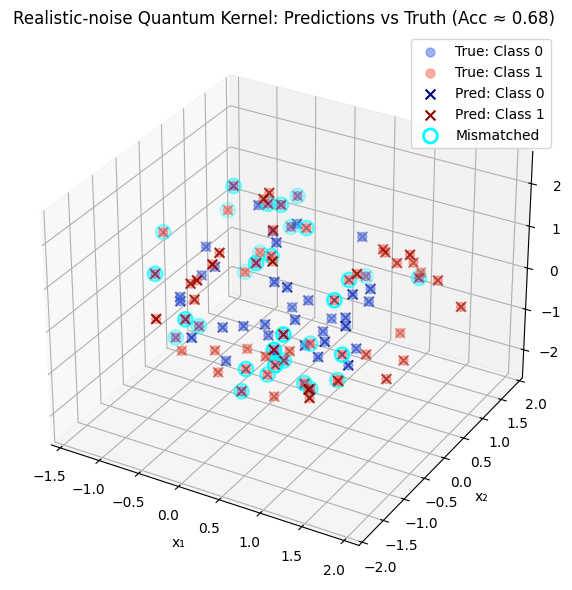

Mismatches: 32 / 100


In [64]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Find mismatches
mismatch_idx = np.where(y_te_sub != y_pred_hard)[0]

fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111, projection='3d')

# True labels (blue / red dots)
ax.scatter(X_te[:len(y_te_sub)][y_te_sub==0,0], 
           X_te[:len(y_te_sub)][y_te_sub==0,1],
           X_te[:len(y_te_sub)][y_te_sub==0,2],
           color='royalblue', alpha=0.5, s=40, label='True: Class 0')

ax.scatter(X_te[:len(y_te_sub)][y_te_sub==1,0],
           X_te[:len(y_te_sub)][y_te_sub==1,1],
           X_te[:len(y_te_sub)][y_te_sub==1,2],
           color='tomato', alpha=0.5, s=40, label='True: Class 1')

# Predicted labels (X markers)
ax.scatter(X_te[:len(y_pred_hard)][y_pred_hard==0,0], 
           X_te[:len(y_pred_hard)][y_pred_hard==0,1],
           X_te[:len(y_pred_hard)][y_pred_hard==0,2],
           color='navy', marker='x', s=50, label='Pred: Class 0')

ax.scatter(X_te[:len(y_pred_hard)][y_pred_hard==1,0],
           X_te[:len(y_pred_hard)][y_pred_hard==1,1],
           X_te[:len(y_pred_hard)][y_pred_hard==1,2],
           color='darkred', marker='x', s=50, label='Pred: Class 1')

# Highlight mismatches (cyan circles)
if len(mismatch_idx) > 0:
    ax.scatter(X_te[:len(y_te_sub)][mismatch_idx,0],
               X_te[:len(y_te_sub)][mismatch_idx,1],
               X_te[:len(y_te_sub)][mismatch_idx,2],
               s=100, edgecolors='cyan', facecolors='none', linewidths=2, label='Mismatched')

ax.set_title("Realistic-noise Quantum Kernel: Predictions vs Truth (Acc ≈ {:.2f})".format(acc_hard))
ax.set_xlabel('x₁'); ax.set_ylabel('x₂'); ax.set_zlabel('x₃')
ax.legend()
plt.tight_layout()
plt.show()

print(f"Mismatches: {len(mismatch_idx)} / {len(y_te_sub)}")


/tmp/ipykernel_735245/2677709776.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


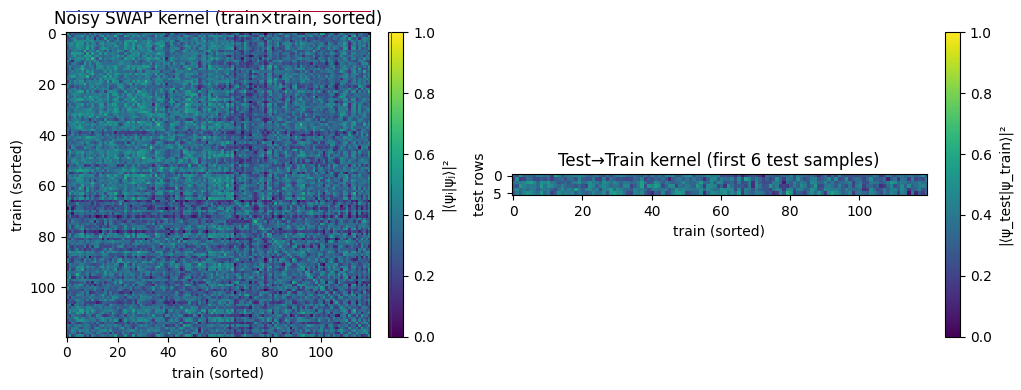

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Inputs expected:
# Ktr_hard  : (ntr, ntr) train×train kernel
# Kte_hard  : (nte, ntr) test×train kernel
# y_tr_sub  : (ntr,) train labels
# y_te_sub  : (nte,) test labels

# 1) sort train by label for block structure
order = np.argsort(y_tr_sub)
Ktr_sorted = Ktr_hard[np.ix_(order, order)]
y_sorted   = y_tr_sub[order]

# 2) plot heatmaps
fig, ax = plt.subplots(1, 2, figsize=(11, 4))

# --- left: train×train kernel (sorted) ---
im = ax[0].imshow(Ktr_sorted, cmap='viridis', vmin=0, vmax=1, interpolation='nearest')
ax[0].set_title("Noisy SWAP kernel (train×train, sorted)")
ax[0].set_xlabel("train (sorted)")
ax[0].set_ylabel("train (sorted)")
cbar = plt.colorbar(im, ax=ax[0], fraction=0.046, pad=0.04)
cbar.set_label("|⟨ψᵢ|ψⱼ⟩|²")

# add label strips via inset axes (no shared axes!)
top_ax = inset_axes(ax[0], width="100%", height="5%",
                    loc='upper center', bbox_to_anchor=(0, 1.02, 1, 0.05),
                    bbox_transform=ax[0].transAxes, borderpad=0)
top_ax.imshow(y_sorted[None, :], cmap='coolwarm', aspect='auto', vmin=0, vmax=1)
top_ax.axis('off')

right_ax = inset_axes(ax[0], width="5%", height="100%",
                      loc='center right', bbox_to_anchor=(1.02, 0, 0.05, 1),
                      bbox_transform=ax[0].transAxes, borderpad=0)
right_ax.imshow(y_sorted[:, None], cmap='coolwarm', aspect='auto', vmin=0, vmax=1)
right_ax.axis('off')

# --- right: first few test rows vs all train (sorted) ---
rows_to_show = min(6, Kte_hard.shape[0])
im2 = ax[1].imshow(Kte_hard[:rows_to_show, order], cmap='viridis',
                   vmin=0, vmax=1, interpolation='nearest')
ax[1].set_title(f"Test→Train kernel (first {rows_to_show} test samples)")
ax[1].set_xlabel("train (sorted)")
ax[1].set_ylabel("test rows")
cbar2 = plt.colorbar(im2, ax=ax[1], fraction=0.046, pad=0.04)
cbar2.set_label("|⟨ψ_test|ψ_train⟩|²")

plt.tight_layout()
plt.show()


### Left panel — “Noisy SWAP kernel (train×train, sorted)”

##### Each cell = quantum kernel value $ |⟨ψᵢ|ψⱼ⟩|² $ between two training states.

Because sorted by label, the top-left and bottom-right corners correspond to same-class pairs.

Ideally, you’d see brighter squares along the diagonal (within-class similarity high)
and darker areas off the diagonal (between-class similarity low)


mostly grainy blue-green (around 0.4–0.7 values) — this means:

The classes overlap heavily in feature space.

Quantum embeddings are noisy (low separability).

The model’s 0.68 accuracy matches this structure: there’s no clean boundary.


### Right panel , Test→Train kernel (first 6 test samples)” :

Each row corresponds to a single test sample.

The row shows how similar that test state is to every train sample (sorted by class).

Ideally, rows from one class “light up” mostly in the block corresponding to that class.

In our plot, rows are fuzzy and spread out → the quantum model can’t distinguish perfectly, matching our noisy setup.


| Part          | What It Shows                    | What It Means                       |
| ------------- | -------------------------------- | ----------------------------------- |
| Left heatmap  | Train–train similarity structure | Shows class overlap due to noise    |
| Right heatmap | Test–train similarity per sample | Confirms uncertainty in predictions |
| Warning       | From `tight_layout()`            | Safe to ignore                      |


# Summary & Conclusion of this project 

This project explored a quantum kernel learning approach built on the SWAP test, a quantum circuit used to measure the similarity (fidelity) between quantum states. Classical 3D data points were encoded into quantum states, and the SWAP test was used to form a quantum kernel matrix for classification.
We introduced and analyzed the impact of different quantum noise models — depolarizing, amplitude damping, and readout errors — to simulate realistic hardware conditions. The model initially achieved high fidelity and accuracy on clean simulations but showed gradual degradation under noise (accuracy ≈ 0.8 → 0.68), confirming the sensitivity of quantum states to decoherence.
Kernel heatmaps and 3D visualizations revealed how noise disrupts the geometry of quantum feature space, leading to less distinct class boundaries.
Overall, this work demonstrates that quantum similarity-based learning can effectively capture data structure while exposing how quantum noise affects information encoding — an important insight for developing robust, noise-tolerant quantum ML models for near-term quantum devices.